### Preparación y verificación del dataset

In [2]:
# importamos librerías esenciales
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# descargamos datos de entrenamiento
train_data= datasets.FashionMNIST(root= 'data', train= True, download= True, transform= ToTensor(),)

# descargamos datos de testeo
test_data= datasets.FashionMNIST(root= 'data', train= False, download= True, transform= ToTensor(),)

100%|██████████| 26421880/26421880 [00:02<00:00, 10302256.80it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw






100%|██████████| 29515/29515 [00:00<00:00, 174952.60it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw






100%|██████████| 4422102/4422102 [00:01<00:00, 3237504.41it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw






100%|██████████| 5148/5148 [00:00<00:00, 5738048.63it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw




In [4]:
# graficamos todas las clases con sus respectivas etiquetas
labels_map={
    0: 'T-shirt',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle Boot',
}

figure = plt.figure(figsize = (10,10))
cols, rows = 3, 3

for i in range (1, cols*rows + 1):
    sample_idx = torch.randint(len(train_data), size = (1,)).item()
    image, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis('off')
    plt.imshow(image.squeeze(), cmap='gray')
plt.show()

In [5]:
# configuramos el device acorde al device disponible
device = "cuda" if torch.cuda.is_available() else "cpu"

In [6]:
# creamos los batches con Datalodader
dataloader = {
    'train': torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
}

In [7]:
# verificamos los types
print(type(dataloader))
print(type(dataloader['train']))

<class 'dict'>

<class 'torch.utils.data.dataloader.DataLoader'>


In [8]:
# capturamos la imagen y etiqueta del dataloader
train_features, train_labels = next(iter(dataloader['train']))

Tamaño del batch de feature (input / imagen): torch.Size([64, 1, 28, 28])

Tamaño del batch del label (clase / etiqueta): torch.Size([64])

tamaño de 1 imagen:  torch.Size([1, 28, 28])

tamaño de 1 imagen DESPUES de squeeze:  torch.Size([28, 28])


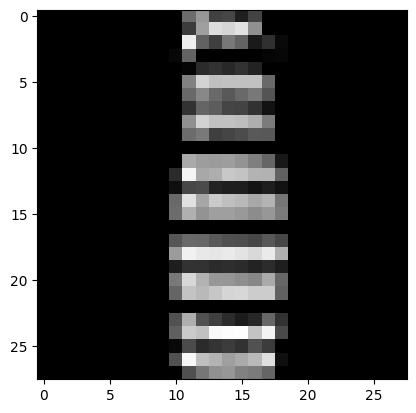

Label: 3


In [9]:
# verificamos las dimensiones
print(f"Tamaño del batch de feature (input / imagen): {train_features.size()}")
print(f"Tamaño del batch del label (clase / etiqueta): {train_labels.size()}")

# tomo 1 imagen para poder visualizarla y verifico sus dimensiones

img = train_features[22]
print('tamaño de 1 imagen: ', img.shape)
# le QUITO 1 dimension (la del tamaño del batch) para poder graficar
img = img.squeeze()
print('tamaño de 1 imagen DESPUES de squeeze: ', img.shape)
label = train_labels[22]

# ploteo esa imagen
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

### Creación del _model_0_, nuestro modelo base
Más tarde se crearán otros modelos alternativos, variando los hiperparámetros originales.

In [47]:
# bloque de convolución para emplear en la red
def conv_block(c_in, c_out, k=5, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [12]:
# creamos la clase
class CNN_0(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(512, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)
    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [13]:
model_0= CNN_0()

Red creada

arquitectura:

CNN_0(

  (conv1): Sequential(

    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=512, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  5

Número total de parámetros a entrenar:  21386


In [14]:
# resumen de la red creada
from torchsummary import summary
summary(model_0.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1            [-1, 8, 28, 28]             208

              Tanh-2            [-1, 8, 28, 28]               0

         MaxPool2d-3            [-1, 8, 14, 14]               0

            Conv2d-4           [-1, 16, 14, 14]           3,216

              Tanh-5           [-1, 16, 14, 14]               0

         MaxPool2d-6             [-1, 16, 7, 7]               0

            Conv2d-7             [-1, 32, 7, 7]          12,832

              Tanh-8             [-1, 32, 7, 7]               0

         MaxPool2d-9             [-1, 32, 4, 4]               0

           Linear-10                   [-1, 10]           5,130

          Softmax-11            [-1, 1, 28, 28]               0


Total params: 21,386

Trainable params: 21,386

Non-trainable params: 0

----------------------------------------------------------------

Input size (M

In [37]:
model_0.cpu()
model_0.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 8, 14, 14])

Tamaño salida conv2:  torch.Size([1, 16, 7, 7])

Tamaño salida conv3:  torch.Size([1, 32, 4, 4])

Tamaño imagen vectorizada:  torch.Size([1, 512])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [15]:
# definimos la función necesaria para el entrenamiento, graficando las métricas de entrenamiento y testeo
def fit(model, dataloader, epochs=15):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    criterion = torch.nn.CrossEntropyLoss()
    epoch_t_loss = []
    epoch_v_loss = []
    epoch_t_acc = []
    epoch_v_acc = []
    for epoch in range(1, epochs+1):
        model.train()
        train_loss, train_acc = [], []
        bar = tqdm(dataloader['train'])
        for batch in bar:
            X, y = batch
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            ####
            acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
            train_acc.append(acc)
            bar.set_description(f"loss {np.mean(train_loss):.5f} acc {np.mean(train_acc):.5f}")

        epoch_t_loss.append(np.mean(train_loss))
        epoch_t_acc.append(np.mean(train_acc))

        bar = tqdm(dataloader['test'])
        val_loss, val_acc = [], []
        model.eval()
        with torch.no_grad():
            for batch in bar:
                X, y = batch
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                loss = criterion(y_hat, y)
                val_loss.append(loss.item())
                acc = (y == torch.argmax(y_hat, axis=1)).sum().item() / len(y)
                val_acc.append(acc)
                bar.set_description(f"val_loss {np.mean(val_loss):.5f} val_acc {np.mean(val_acc):.5f}")
        print(f"Epoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} val_loss {np.mean(val_loss):.5f} acc {np.mean(train_acc):.5f} val_acc {np.mean(val_acc):.5f}")

        epoch_v_loss.append(np.mean(val_loss))
        epoch_v_acc.append(np.mean(val_acc))

    plt.figure()
    plt.plot(epoch_t_loss, 'r')
    plt.plot(epoch_v_loss, 'g')
    plt.title('loss')
    plt.legend(['train loss', 'val loss'])
    plt.grid()

    plt.figure()
    plt.plot(epoch_t_acc, 'r')
    plt.plot(epoch_v_acc, 'g')
    plt.title('acc')
    plt.legend(['train acc', 'val acc'])
    plt.grid()
    plt.show()

    return {
        'model': model,
        'optimizer': optimizer,
    }

loss 1.04236 acc 0.65590: 100%|██████████| 938/938 [00:16<00:00, 57.43it/s]

val_loss 0.67020 val_acc 0.75746: 100%|██████████| 157/157 [00:01<00:00, 87.88it/s]


Epoch 1/5 loss 1.04236 val_loss 0.67020 acc 0.65590 val_acc 0.75746


loss 0.59573 acc 0.77993: 100%|██████████| 938/938 [00:13<00:00, 70.78it/s]

val_loss 0.56896 val_acc 0.79080: 100%|██████████| 157/157 [00:01<00:00, 88.22it/s]


Epoch 2/5 loss 0.59573 val_loss 0.56896 acc 0.77993 val_acc 0.79080


loss 0.52227 acc 0.80830: 100%|██████████| 938/938 [00:13<00:00, 70.13it/s]

val_loss 0.51521 val_acc 0.81071: 100%|██████████| 157/157 [00:01<00:00, 88.30it/s]


Epoch 3/5 loss 0.52227 val_loss 0.51521 acc 0.80830 val_acc 0.81071


loss 0.47576 acc 0.82508: 100%|██████████| 938/938 [00:13<00:00, 70.16it/s]

val_loss 0.47513 val_acc 0.82385: 100%|██████████| 157/157 [00:02<00:00, 77.92it/s]


Epoch 4/5 loss 0.47576 val_loss 0.47513 acc 0.82508 val_acc 0.82385


loss 0.44175 acc 0.83850: 100%|██████████| 938/938 [00:13<00:00, 71.00it/s]

val_loss 0.44769 val_acc 0.83529: 100%|██████████| 157/157 [00:02<00:00, 69.70it/s]


Epoch 5/5 loss 0.44175 val_loss 0.44769 acc 0.83850 val_acc 0.83529


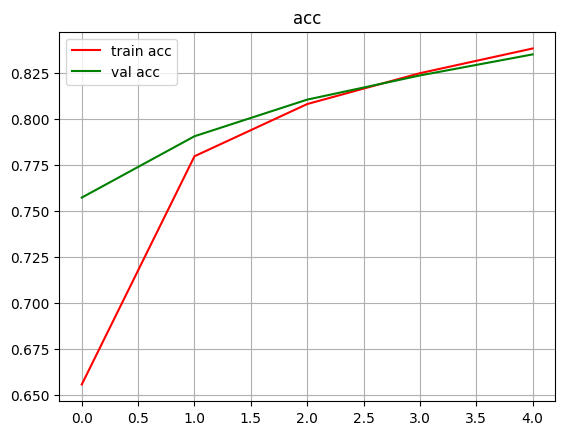

In [53]:
results_model_0= fit(model_0, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 5x5**:

- train loss = 0.44175
- validation loss = 0.44769

- train accuracy = 83.850%
- validation accuracy = 83.529%

***

### Creación del _model_1_
Una capa de convolución adicional (4 en total).

In [54]:
# creamos la clase
class CNN_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block(16, 32)
    self.conv3_out = None
    self.conv4 = conv_block(32, 64)
    self.conv4_out = None
    self.fc = torch.nn.Linear(256, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)
    x = self.conv4(x)
    print("Tamaño salida conv4: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.conv4_out = self.conv4(self.conv3_out)
    y = self.conv4_out.view(self.conv4_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [56]:
model_1= CNN_1()

Red creada

arquitectura:

CNN_1(

  (conv1): Sequential(

    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv4): Sequential(

    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=256, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + fi

In [ ]:
# resumen de la red
summary(model_1.cuda(),(1, 28, 28) )

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1            [-1, 8, 28, 28]             208

              Tanh-2            [-1, 8, 28, 28]               0

         MaxPool2d-3            [-1, 8, 14, 14]               0

            Conv2d-4           [-1, 16, 14, 14]           3,216

              Tanh-5           [-1, 16, 14, 14]               0

         MaxPool2d-6             [-1, 16, 7, 7]               0

            Conv2d-7             [-1, 32, 7, 7]          12,832

              Tanh-8             [-1, 32, 7, 7]               0

         MaxPool2d-9             [-1, 32, 4, 4]               0

           Conv2d-10             [-1, 64, 4, 4]          51,264

             Tanh-11             [-1, 64, 4, 4]               0

        MaxPool2d-12             [-1, 64, 2, 2]               0

           Linear-13                   [-1, 10]           2,570

          Softmax-14   

In [ ]:
model_1.cpu()
model_1.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 8, 14, 14])

Tamaño salida conv2:  torch.Size([1, 16, 7, 7])

Tamaño salida conv3:  torch.Size([1, 32, 4, 4])

Tamaño salida conv4:  torch.Size([1, 64, 2, 2])

Tamaño imagen vectorizada:  torch.Size([1, 256])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 0.98544 acc 0.66430: 100%|██████████| 938/938 [00:13<00:00, 68.39it/s]

val_loss 0.64054 val_acc 0.75587: 100%|██████████| 157/157 [00:01<00:00, 90.51it/s]


Epoch 1/5 loss 0.98544 val_loss 0.64054 acc 0.66430 val_acc 0.75587


loss 0.57058 acc 0.78337: 100%|██████████| 938/938 [00:13<00:00, 67.18it/s]

val_loss 0.54726 val_acc 0.79638: 100%|██████████| 157/157 [00:02<00:00, 73.10it/s]


Epoch 2/5 loss 0.57058 val_loss 0.54726 acc 0.78337 val_acc 0.79638


loss 0.50001 acc 0.81228: 100%|██████████| 938/938 [00:14<00:00, 66.94it/s]

val_loss 0.49401 val_acc 0.81618: 100%|██████████| 157/157 [00:01<00:00, 87.59it/s]


Epoch 3/5 loss 0.50001 val_loss 0.49401 acc 0.81228 val_acc 0.81618


loss 0.45341 acc 0.83164: 100%|██████████| 938/938 [00:13<00:00, 68.06it/s]

val_loss 0.45379 val_acc 0.82902: 100%|██████████| 157/157 [00:01<00:00, 88.52it/s]


Epoch 4/5 loss 0.45341 val_loss 0.45379 acc 0.83164 val_acc 0.82902


loss 0.42017 acc 0.84433: 100%|██████████| 938/938 [00:13<00:00, 67.81it/s]

val_loss 0.43305 val_acc 0.83748: 100%|██████████| 157/157 [00:01<00:00, 89.77it/s]


Epoch 5/5 loss 0.42017 val_loss 0.43305 acc 0.84433 val_acc 0.83748


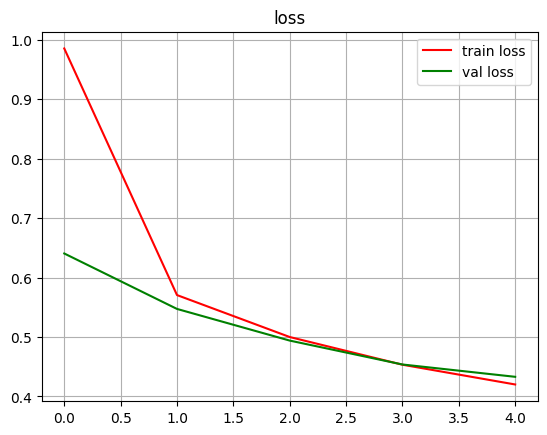

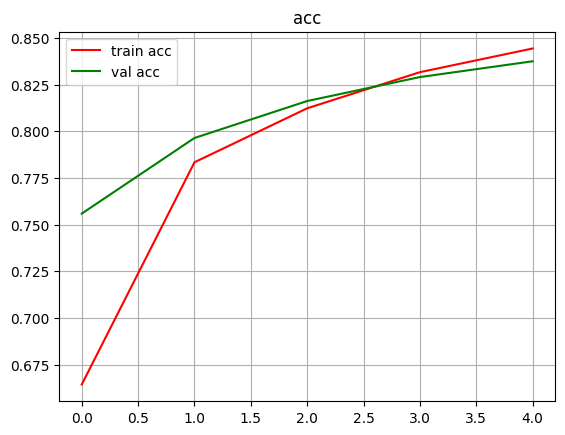

In [57]:
results_model_1= fit(model_1, dataloader, epochs=5)

Métricas obtenidas para un modelo con **4 capas de convolución**, **8 kernels** de **tamaño 5x5**:

- train loss = 0.42017
- validation loss = 0.43305

- train accuracy = 84.433%
- validation accuracy = 83.748%

***

### Creación del _model_2_
Aumentamos el número de kernels (16 en la primer capa).

In [58]:
# creamos la clase
class CNN_2(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 16)
    self.conv1_out = None
    self.conv2 = conv_block(16, 32)
    self.conv2_out = None
    self.conv3 = conv_block(32, 64)
    self.conv3_out = None
    self.fc = torch.nn.Linear(1024, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [59]:
model_2= CNN_2()

Red creada

arquitectura:

CNN_2(

  (conv1): Sequential(

    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=1024, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  5

Número total de parámetros a entrenar:  74762


In [ ]:
# resumen de la red
summary(model_2.cuda(),(1, 28, 28) )

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 16, 28, 28]             416

              Tanh-2           [-1, 16, 28, 28]               0

         MaxPool2d-3           [-1, 16, 14, 14]               0

            Conv2d-4           [-1, 32, 14, 14]          12,832

              Tanh-5           [-1, 32, 14, 14]               0

         MaxPool2d-6             [-1, 32, 7, 7]               0

            Conv2d-7             [-1, 64, 7, 7]          51,264

              Tanh-8             [-1, 64, 7, 7]               0

         MaxPool2d-9             [-1, 64, 4, 4]               0

           Linear-10                   [-1, 10]          10,250

          Softmax-11            [-1, 1, 28, 28]               0


Total params: 74,762

Trainable params: 74,762

Non-trainable params: 0

----------------------------------------------------------------

Input size (M

In [ ]:
model_2.cpu()
model_2.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 16, 14, 14])

Tamaño salida conv2:  torch.Size([1, 32, 7, 7])

Tamaño salida conv3:  torch.Size([1, 64, 4, 4])

Tamaño imagen vectorizada:  torch.Size([1, 1024])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 0.81409 acc 0.73083: 100%|██████████| 938/938 [00:14<00:00, 65.52it/s]

val_loss 0.57079 val_acc 0.78782: 100%|██████████| 157/157 [00:02<00:00, 78.46it/s]


Epoch 1/5 loss 0.81409 val_loss 0.57079 acc 0.73083 val_acc 0.78782


loss 0.50022 acc 0.81615: 100%|██████████| 938/938 [00:13<00:00, 68.99it/s]

val_loss 0.47627 val_acc 0.82594: 100%|██████████| 157/157 [00:02<00:00, 77.08it/s]


Epoch 2/5 loss 0.50022 val_loss 0.47627 acc 0.81615 val_acc 0.82594


loss 0.43115 acc 0.84268: 100%|██████████| 938/938 [00:14<00:00, 66.24it/s]

val_loss 0.42636 val_acc 0.84664: 100%|██████████| 157/157 [00:01<00:00, 81.19it/s]


Epoch 3/5 loss 0.43115 val_loss 0.42636 acc 0.84268 val_acc 0.84664


loss 0.38716 acc 0.86039: 100%|██████████| 938/938 [00:13<00:00, 68.86it/s]

val_loss 0.40089 val_acc 0.85510: 100%|██████████| 157/157 [00:01<00:00, 91.03it/s]


Epoch 4/5 loss 0.38716 val_loss 0.40089 acc 0.86039 val_acc 0.85510


loss 0.35914 acc 0.86959: 100%|██████████| 938/938 [00:13<00:00, 70.86it/s]

val_loss 0.37365 val_acc 0.86346: 100%|██████████| 157/157 [00:01<00:00, 93.44it/s]


Epoch 5/5 loss 0.35914 val_loss 0.37365 acc 0.86959 val_acc 0.86346


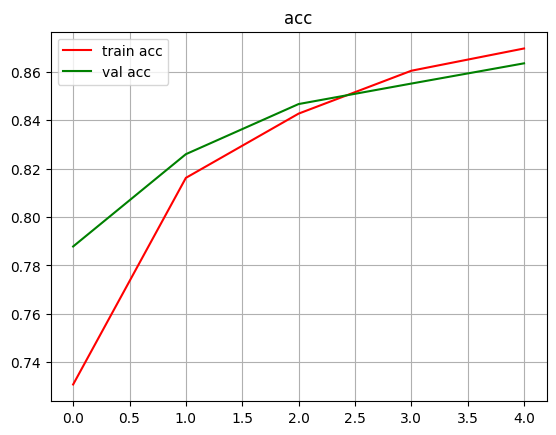

In [60]:
results_model_2= fit(model_2, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **16 kernels** de **tamaño 5x5**:

- train loss = 0.35914
- validation loss = 0.37365

- train accuracy = 86.959%
- validation accuracy = 86.346%

***

### Creación del _model_3_
Se reduce el tamaño de los kernels (quedan en 3x3).

In [61]:
# bloque de convolución para emplear en la red (k es el tamaño de los kernels)

def conv_block_1(c_in, c_out, k=3, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [62]:
# creamos la clase
class CNN_3(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_1(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_1(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_1(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(1152, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [63]:
model_3= CNN_3()

Red creada

arquitectura:

CNN_3(

  (conv1): Sequential(

    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=1152, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  5

Número total de parámetros a entrenar:  17418


In [ ]:
# resumen de la red
summary(model_3.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1            [-1, 8, 30, 30]              80

              Tanh-2            [-1, 8, 30, 30]               0

         MaxPool2d-3            [-1, 8, 15, 15]               0

            Conv2d-4           [-1, 16, 17, 17]           1,168

              Tanh-5           [-1, 16, 17, 17]               0

         MaxPool2d-6             [-1, 16, 9, 9]               0

            Conv2d-7           [-1, 32, 11, 11]           4,640

              Tanh-8           [-1, 32, 11, 11]               0

         MaxPool2d-9             [-1, 32, 6, 6]               0

           Linear-10                   [-1, 10]          11,530

          Softmax-11            [-1, 1, 28, 28]               0


Total params: 17,418

Trainable params: 17,418

Non-trainable params: 0

----------------------------------------------------------------

Input size (M

In [ ]:
model_3.cpu()
model_3.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 8, 15, 15])

Tamaño salida conv2:  torch.Size([1, 16, 9, 9])

Tamaño salida conv3:  torch.Size([1, 32, 6, 6])

Tamaño imagen vectorizada:  torch.Size([1, 1152])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 1.13513 acc 0.62793: 100%|██████████| 938/938 [00:13<00:00, 71.25it/s]

val_loss 0.74277 val_acc 0.74194: 100%|██████████| 157/157 [00:01<00:00, 90.83it/s]


Epoch 1/5 loss 1.13513 val_loss 0.74277 acc 0.62793 val_acc 0.74194


loss 0.64519 acc 0.77212: 100%|██████████| 938/938 [00:13<00:00, 71.42it/s]

val_loss 0.60416 val_acc 0.78016: 100%|██████████| 157/157 [00:01<00:00, 91.76it/s]


Epoch 2/5 loss 0.64519 val_loss 0.60416 acc 0.77212 val_acc 0.78016


loss 0.55207 acc 0.80229: 100%|██████████| 938/938 [00:13<00:00, 71.53it/s]

val_loss 0.54207 val_acc 0.80314: 100%|██████████| 157/157 [00:01<00:00, 88.49it/s]


Epoch 3/5 loss 0.55207 val_loss 0.54207 acc 0.80229 val_acc 0.80314


loss 0.50518 acc 0.81618: 100%|██████████| 938/938 [00:14<00:00, 64.83it/s]

val_loss 0.50346 val_acc 0.81389: 100%|██████████| 157/157 [00:01<00:00, 88.77it/s]


Epoch 4/5 loss 0.50518 val_loss 0.50346 acc 0.81618 val_acc 0.81389


loss 0.47401 acc 0.82768: 100%|██████████| 938/938 [00:14<00:00, 66.73it/s]

val_loss 0.47735 val_acc 0.82424: 100%|██████████| 157/157 [00:02<00:00, 68.08it/s]


Epoch 5/5 loss 0.47401 val_loss 0.47735 acc 0.82768 val_acc 0.82424


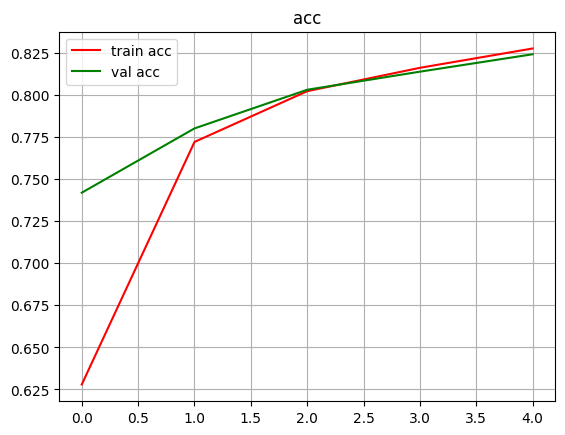

In [64]:
results_3= fit(model_3, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 3x3**:

- train loss = 0.47401
- validation loss = 0.47735

- train accuracy = 82.768%
- validation accuracy = 82.424%

***

### Creación del _model_4_
Aumentamos aún más el número de kernels (32 en la primer capa).

In [65]:
# creamos la clase
class CNN_4(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [66]:
model_4= CNN_4()

Red creada

arquitectura:

CNN_4(

  (conv1): Sequential(

    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=2048, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  5

Número total de parámetros a entrenar:  277514


In [ ]:
# resumen de la red
summary(model_4.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 32, 28, 28]             832

              Tanh-2           [-1, 32, 28, 28]               0

         MaxPool2d-3           [-1, 32, 14, 14]               0

            Conv2d-4           [-1, 64, 14, 14]          51,264

              Tanh-5           [-1, 64, 14, 14]               0

         MaxPool2d-6             [-1, 64, 7, 7]               0

            Conv2d-7            [-1, 128, 7, 7]         204,928

              Tanh-8            [-1, 128, 7, 7]               0

         MaxPool2d-9            [-1, 128, 4, 4]               0

           Linear-10                   [-1, 10]          20,490

          Softmax-11            [-1, 1, 28, 28]               0


Total params: 277,514

Trainable params: 277,514

Non-trainable params: 0

----------------------------------------------------------------

Input size 

In [ ]:
model_4.cpu()
model_4.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 32, 14, 14])

Tamaño salida conv2:  torch.Size([1, 64, 7, 7])

Tamaño salida conv3:  torch.Size([1, 128, 4, 4])

Tamaño imagen vectorizada:  torch.Size([1, 2048])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


In [67]:
results_model_4= fit(model_4, dataloader, epochs=5)

loss 0.67860 acc 0.76229: 100%|██████████| 938/938 [00:15<00:00, 59.85it/s]

val_loss 0.50218 val_acc 0.81310: 100%|██████████| 157/157 [00:02<00:00, 69.38it/s]


Epoch 1/5 loss 0.67860 val_loss 0.50218 acc 0.76229 val_acc 0.81310


loss 0.42611 acc 0.84430: 100%|██████████| 938/938 [00:15<00:00, 59.96it/s]

val_loss 0.41741 val_acc 0.84684: 100%|██████████| 157/157 [00:01<00:00, 85.54it/s]


Epoch 2/5 loss 0.42611 val_loss 0.41741 acc 0.84430 val_acc 0.84684


loss 0.36028 acc 0.86994: 100%|██████████| 938/938 [00:15<00:00, 59.89it/s]

val_loss 0.36400 val_acc 0.86833: 100%|██████████| 157/157 [00:01<00:00, 82.14it/s]


Epoch 3/5 loss 0.36028 val_loss 0.36400 acc 0.86994 val_acc 0.86833


loss 0.32527 acc 0.88156: 100%|██████████| 938/938 [00:15<00:00, 59.86it/s]

val_loss 0.33113 val_acc 0.88147: 100%|██████████| 157/157 [00:02<00:00, 66.27it/s]


Epoch 4/5 loss 0.32527 val_loss 0.33113 acc 0.88156 val_acc 0.88147


loss 0.30296 acc 0.88996: 100%|██████████| 938/938 [00:17<00:00, 54.62it/s]

val_loss 0.31526 val_acc 0.88585: 100%|██████████| 157/157 [00:01<00:00, 83.79it/s]


Epoch 5/5 loss 0.30296 val_loss 0.31526 acc 0.88996 val_acc 0.88585


Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5**:

- train loss = 0.30296
- validation loss = 0.31526

- train accuracy = 88.996%
- validation accuracy = 88.585%

***

### Creación del _model_5_
Se aumenta el tamaño de los kernels (quedan en 7x7).

In [68]:
# bloque de convolución para emplear en la red (k es el tamaño de los kernels)

def conv_block_2(c_in, c_out, k=7, p=2, s=1, pk=3, ps=2, pp=1):
    return torch.nn.Sequential(
        torch.nn.Conv2d(c_in, c_out, k, padding=p, stride=s), # conv
        torch.nn.Tanh(),                                      # activation
        torch.nn.MaxPool2d(pk, stride=ps, padding=pp)         # pooling
    )

In [69]:
# creamos la clase
class CNN_5(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block_2(n_channels, 8)
    self.conv1_out = None
    self.conv2 = conv_block_2(8, 16)
    self.conv2_out = None
    self.conv3 = conv_block_2(16, 32)
    self.conv3_out = None
    self.fc = torch.nn.Linear(128, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    y = self.conv3_out.view(self.conv3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [70]:
model_5= CNN_5()

Red creada

arquitectura:

CNN_5(

  (conv1): Sequential(

    (0): Conv2d(1, 8, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(8, 16, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(16, 32, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (fc): Linear(in_features=128, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  5

Número total de parámetros a entrenar:  33098


In [ ]:
# resumen de la red
summary(model_5.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1            [-1, 8, 26, 26]             400

              Tanh-2            [-1, 8, 26, 26]               0

         MaxPool2d-3            [-1, 8, 13, 13]               0

            Conv2d-4           [-1, 16, 11, 11]           6,288

              Tanh-5           [-1, 16, 11, 11]               0

         MaxPool2d-6             [-1, 16, 6, 6]               0

            Conv2d-7             [-1, 32, 4, 4]          25,120

              Tanh-8             [-1, 32, 4, 4]               0

         MaxPool2d-9             [-1, 32, 2, 2]               0

           Linear-10                   [-1, 10]           1,290

          Softmax-11            [-1, 1, 28, 28]               0


Total params: 33,098

Trainable params: 33,098

Non-trainable params: 0

----------------------------------------------------------------

Input size (M

In [ ]:
model_5.cpu()
model_5.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 8, 13, 13])

Tamaño salida conv2:  torch.Size([1, 16, 6, 6])

Tamaño salida conv3:  torch.Size([1, 32, 2, 2])

Tamaño imagen vectorizada:  torch.Size([1, 128])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 1.01719 acc 0.67252: 100%|██████████| 938/938 [00:14<00:00, 65.20it/s]

val_loss 0.68623 val_acc 0.74423: 100%|██████████| 157/157 [00:01<00:00, 87.65it/s]


Epoch 1/5 loss 1.01719 val_loss 0.68623 acc 0.67252 val_acc 0.74423


loss 0.60822 acc 0.77111: 100%|██████████| 938/938 [00:14<00:00, 66.14it/s]

val_loss 0.57799 val_acc 0.78732: 100%|██████████| 157/157 [00:01<00:00, 86.23it/s]


Epoch 2/5 loss 0.60822 val_loss 0.57799 acc 0.77111 val_acc 0.78732


loss 0.52971 acc 0.80166: 100%|██████████| 938/938 [00:13<00:00, 67.44it/s]

val_loss 0.52304 val_acc 0.80494: 100%|██████████| 157/157 [00:01<00:00, 85.47it/s]


Epoch 3/5 loss 0.52971 val_loss 0.52304 acc 0.80166 val_acc 0.80494


loss 0.48201 acc 0.82268: 100%|██████████| 938/938 [00:13<00:00, 67.94it/s]

val_loss 0.48997 val_acc 0.81529: 100%|██████████| 157/157 [00:02<00:00, 71.03it/s]


Epoch 4/5 loss 0.48201 val_loss 0.48997 acc 0.82268 val_acc 0.81529


loss 0.44894 acc 0.83592: 100%|██████████| 938/938 [00:13<00:00, 67.75it/s]

val_loss 0.45548 val_acc 0.83280: 100%|██████████| 157/157 [00:01<00:00, 83.30it/s]


Epoch 5/5 loss 0.44894 val_loss 0.45548 acc 0.83592 val_acc 0.83280


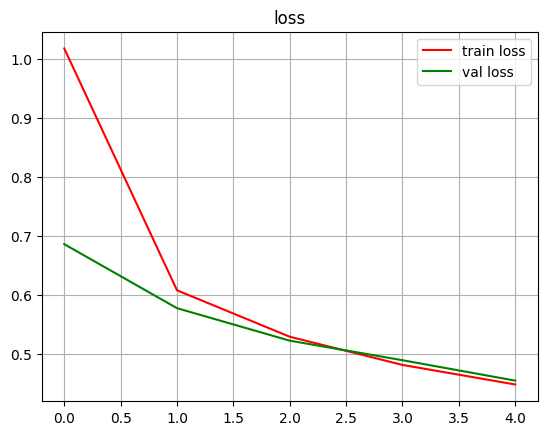

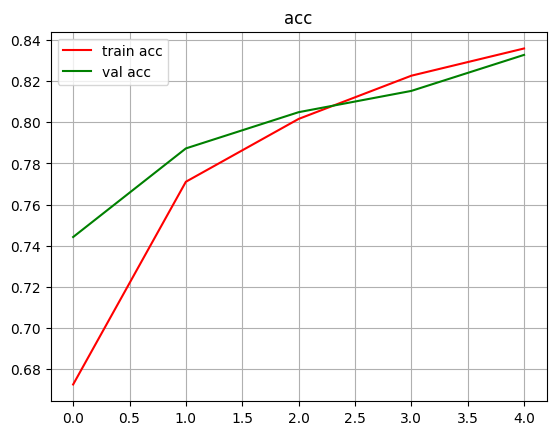

In [71]:
results_model_5= fit(model_5, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **8 kernels** de **tamaño 7x7**:

- train loss = 0.44894
- validation loss = 0.45548

- train accuracy = 83.592%
- validation accuracy = 83.280%

***

### Elección del mejor modelo
Al observar las métricas obtenidas por cada uno de los modelos, se concluye que el mejor desempeño se ha obtenido con el **model_4**, el cual *aumentó el número de kernels en la primer capa de 8 a 32*, con respecto al model_0.

### Adición de capas de dropout
Le añadiremos capas droput a model_4 para intentar mejorar la performance del modelo.

En la siguiente red, añadimos 3 capas de droput intermedias con *p= 0.5*.

In [72]:
# creamos la clase
class CNN_4_dropout(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.dropout1 = nn.Dropout(p=0.5)
    self.dropout1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.dropout2 = nn.Dropout(p=0.5)
    self.dropout2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.dropout3 = nn.Dropout(p=0.5)
    self.dropout3_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)


    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.dropout1_out = self.dropout1(self.conv1_out)
    self.conv2_out = self.conv2(self.dropout1_out)
    self.dropout2_out = self.dropout2(self.conv2_out)
    self.conv3_out = self.conv3(self.dropout2_out)
    self.dropout3_out = self.dropout3(self.conv3_out)
    y = self.dropout3_out.view(self.dropout3_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [73]:
model_4_dropout= CNN_4_dropout()

Red creada

arquitectura:

CNN_4_dropout(

  (conv1): Sequential(

    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (dropout1): Dropout(p=0.5, inplace=False)

  (conv2): Sequential(

    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (dropout2): Dropout(p=0.5, inplace=False)

  (conv3): Sequential(

    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (dropout3): Dropout(p=0.5, inplace=False)

  (fc): Linear(in_features=2048, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  8

Número total de parámetros a entrenar:  277514


In [ ]:
# resumen de la red
summary(model_4_dropout.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 32, 28, 28]             832

              Tanh-2           [-1, 32, 28, 28]               0

         MaxPool2d-3           [-1, 32, 14, 14]               0

           Dropout-4           [-1, 32, 14, 14]               0

            Conv2d-5           [-1, 64, 14, 14]          51,264

              Tanh-6           [-1, 64, 14, 14]               0

         MaxPool2d-7             [-1, 64, 7, 7]               0

           Dropout-8             [-1, 64, 7, 7]               0

            Conv2d-9            [-1, 128, 7, 7]         204,928

             Tanh-10            [-1, 128, 7, 7]               0

        MaxPool2d-11            [-1, 128, 4, 4]               0

          Dropout-12            [-1, 128, 4, 4]               0

           Linear-13                   [-1, 10]          20,490

          Softmax-14   

In [ ]:
model_4_dropout.cpu()
model_4_dropout.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 32, 14, 14])

Tamaño salida conv2:  torch.Size([1, 64, 7, 7])

Tamaño salida conv3:  torch.Size([1, 128, 4, 4])

Tamaño imagen vectorizada:  torch.Size([1, 2048])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 0.89423 acc 0.67714: 100%|██████████| 938/938 [00:15<00:00, 59.87it/s]

val_loss 0.60275 val_acc 0.77518: 100%|██████████| 157/157 [00:01<00:00, 84.95it/s]


Epoch 1/5 loss 0.89423 val_loss 0.60275 acc 0.67714 val_acc 0.77518


loss 0.57241 acc 0.78553: 100%|██████████| 938/938 [00:15<00:00, 60.64it/s]

val_loss 0.51372 val_acc 0.80882: 100%|██████████| 157/157 [00:02<00:00, 69.02it/s]


Epoch 2/5 loss 0.57241 val_loss 0.51372 acc 0.78553 val_acc 0.80882


loss 0.50227 acc 0.81322: 100%|██████████| 938/938 [00:16<00:00, 58.49it/s]

val_loss 0.45623 val_acc 0.83609: 100%|██████████| 157/157 [00:01<00:00, 83.97it/s]


Epoch 3/5 loss 0.50227 val_loss 0.45623 acc 0.81322 val_acc 0.83609


loss 0.45782 acc 0.83074: 100%|██████████| 938/938 [00:15<00:00, 58.89it/s]

val_loss 0.42646 val_acc 0.84385: 100%|██████████| 157/157 [00:01<00:00, 82.22it/s]


Epoch 4/5 loss 0.45782 val_loss 0.42646 acc 0.83074 val_acc 0.84385


loss 0.42499 acc 0.84342: 100%|██████████| 938/938 [00:16<00:00, 57.75it/s]

val_loss 0.40407 val_acc 0.85251: 100%|██████████| 157/157 [00:02<00:00, 68.28it/s]


Epoch 5/5 loss 0.42499 val_loss 0.40407 acc 0.84342 val_acc 0.85251


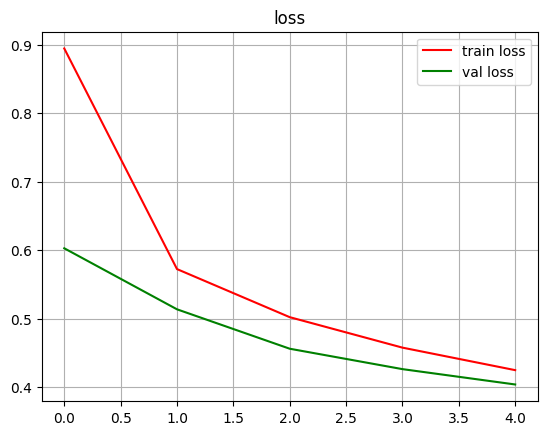

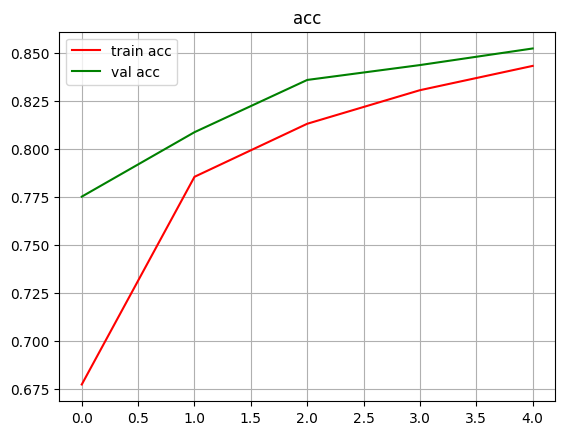

In [74]:
results_model_4_dropout= fit(model_4_dropout, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5** y **capas dropout intermedias**:

- train loss = 0.42499
- validation loss = 0.40407

- train accuracy = 84.342%
- validation accuracy = 85.251%

Como se puede observar, **este modelo ha empeorado su performance respecto a la versión sin capas de dropout**.

A continuación, creamos otro modelo con una única capa de dropout a la salida de la última capa de convulución, con una *p= 0.2*.

In [67]:
# creamos la clase
class CNN_4_dropout_1(torch.nn.Module):
  def __init__(self, n_channels=1, n_outputs=10):
    super().__init__()
    self.conv1 = conv_block(n_channels, 32)
    self.conv1_out = None
    self.conv2 = conv_block(32, 64)
    self.conv2_out = None
    self.conv3 = conv_block(64, 128)
    self.conv3_out = None
    self.dropout = nn.Dropout(p=0.2)
    self.dropout_out = None
    self.fc = torch.nn.Linear(2048, n_outputs)
    self.sm = torch.nn.Softmax(dim=1)

    print('Red creada')
    print('arquitectura:')
    print(self)

    # verificamos el número de capas
    i=0
    for layer in self.children():
        i=i+1
    print('Número total de capas de CNN (conv+act+polling) + finales : ', i)

    # chequeamos el número de parámetros entrenables
    pytorch_total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
    print('Número total de parámetros a entrenar: ', pytorch_total_params)

  def validar_dim(self):
    # es una funcion "forward" que imprime la dimension de cada paso
    # la defino distinto de la forward standard para que cuando entrenemos
    # no nos llene la pantalla de información inecesaria.

    print("Validacion de dimensiones")
    tam = input("Ingrese tamaño de entrada: ")
    x = torch.randn(1, 1, int(tam), int(tam))
    print("Tamaño entrada: ", x.shape)

    x = self.conv1(x)
    print("Tamaño salida conv1: ", x.shape)
    x = self.conv2(x)
    print("Tamaño salida conv2: ", x.shape)
    x = self.conv3(x)
    print("Tamaño salida conv3: ", x.shape)

    x = x.view(x.shape[0], -1)
    print("Tamaño imagen vectorizada: ", x.shape)
    x = self.fc(x)
    print("Tamaño salida fc (nro clases): ", x.shape)

  def forward(self, x):
    self.conv1_out = self.conv1(x)
    self.conv2_out = self.conv2(self.conv1_out)
    self.conv3_out = self.conv3(self.conv2_out)
    self.dropout_out = self.dropout(self.conv3_out)
    y = self.dropout_out.view(self.dropout_out.shape[0], -1)
    y = self.fc(y)
    x = self.sm(x)
    return y

In [17]:
model_4_dropout_1= CNN_4_dropout_1()

Red creada

arquitectura:

CNN_4_dropout_1(

  (conv1): Sequential(

    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv2): Sequential(

    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (conv3): Sequential(

    (0): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (1): Tanh()

    (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  )

  (dropout): Dropout(p=0.2, inplace=False)

  (fc): Linear(in_features=2048, out_features=10, bias=True)

  (sm): Softmax(dim=1)

)

Número total de capas de CNN (conv+act+polling) + finales :  6

Número total de parámetros a entrenar:  277514


In [18]:
# resumen de la red
summary(model_4_dropout_1.cuda(),(1, 28, 28))

----------------------------------------------------------------

        Layer (type)               Output Shape         Param #


            Conv2d-1           [-1, 32, 28, 28]             832

              Tanh-2           [-1, 32, 28, 28]               0

         MaxPool2d-3           [-1, 32, 14, 14]               0

            Conv2d-4           [-1, 64, 14, 14]          51,264

              Tanh-5           [-1, 64, 14, 14]               0

         MaxPool2d-6             [-1, 64, 7, 7]               0

            Conv2d-7            [-1, 128, 7, 7]         204,928

              Tanh-8            [-1, 128, 7, 7]               0

         MaxPool2d-9            [-1, 128, 4, 4]               0

          Dropout-10            [-1, 128, 4, 4]               0

           Linear-11                   [-1, 10]          20,490

          Softmax-12            [-1, 1, 28, 28]               0


Total params: 277,514

Trainable params: 277,514

Non-trainable params: 0

------------

In [14]:
model_4_dropout_1.cpu()
model_4_dropout_1.validar_dim()

Validacion de dimensiones

Ingrese tamaño de entrada: 28

Tamaño entrada:  torch.Size([1, 1, 28, 28])

Tamaño salida conv1:  torch.Size([1, 32, 14, 14])

Tamaño salida conv2:  torch.Size([1, 64, 7, 7])

Tamaño salida conv3:  torch.Size([1, 128, 4, 4])

Tamaño imagen vectorizada:  torch.Size([1, 2048])

Tamaño salida fc (nro clases):  torch.Size([1, 10])


loss 0.49853 acc 0.81030: 100%|██████████| 313/313 [00:04<00:00, 63.03it/s]

val_loss 0.19813 val_acc 0.93641: 100%|██████████| 157/157 [00:02<00:00, 73.24it/s]


Epoch 1/5 loss 0.49853 val_loss 0.19813 acc 0.81030 val_acc 0.93641


loss 0.16426 acc 0.94334: 100%|██████████| 313/313 [00:05<00:00, 60.89it/s]

val_loss 0.12854 val_acc 0.95472: 100%|██████████| 157/157 [00:01<00:00, 86.41it/s]


Epoch 2/5 loss 0.16426 val_loss 0.12854 acc 0.94334 val_acc 0.95472


loss 0.11730 acc 0.95907: 100%|██████████| 313/313 [00:05<00:00, 58.16it/s]

val_loss 0.10189 val_acc 0.96367: 100%|██████████| 157/157 [00:04<00:00, 34.43it/s]


Epoch 3/5 loss 0.11730 val_loss 0.10189 acc 0.95907 val_acc 0.96367


loss 0.09485 acc 0.96755: 100%|██████████| 313/313 [00:04<00:00, 63.68it/s]

val_loss 0.08513 val_acc 0.97064: 100%|██████████| 157/157 [00:01<00:00, 86.12it/s]


Epoch 4/5 loss 0.09485 val_loss 0.08513 acc 0.96755 val_acc 0.97064


loss 0.07682 acc 0.97429: 100%|██████████| 313/313 [00:05<00:00, 57.14it/s]

val_loss 0.07404 val_acc 0.97363: 100%|██████████| 157/157 [00:01<00:00, 84.89it/s]


Epoch 5/5 loss 0.07682 val_loss 0.07404 acc 0.97429 val_acc 0.97363


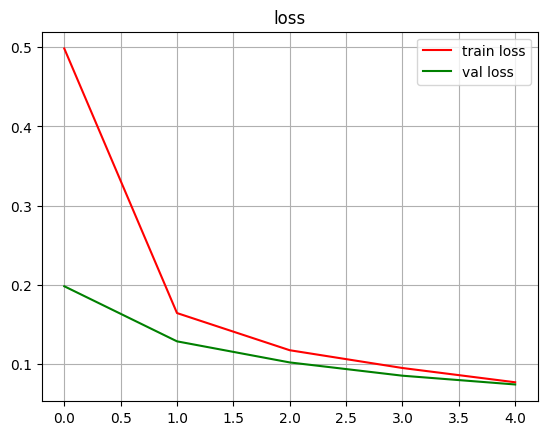

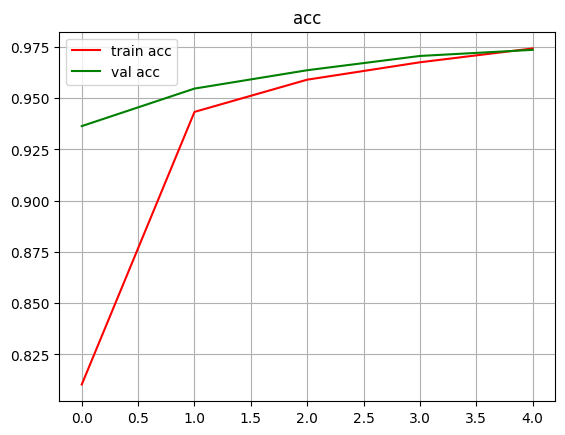

In [68]:
results_model_4_dropout_1= fit(model_4_dropout_1, dataloader, epochs=5)

Métricas obtenidas para un modelo con **3 capas de convolución**, **32 kernels** de **tamaño 5x5** y **1 capa dropout final**:

- train loss = 0.07682
- validation loss = 0.07404

- train accuracy = 97.429%
- validation accuracy = 97.363%

En este caso, hemos obtenido una **importante mejora** en la performance del modelo! Lo guardaremos a fin de tenerlo disponible para futuros trabajos de _transfer learning_.

In [59]:
# guardamos el modelo ya entrenado
checkpoint = {
    'epoch': 5,
    'model_state_dict': results_model_4_dropout_1['model'].state_dict(),
    'optimizer_state_dict': results_model_4_dropout_1['optimizer'].state_dict(),
}

torch.save(checkpoint, 'modelo_entrenado.pth')

### Conclusiones

Hemos buscado alternativas al primer modelo propuesto, y al observar los resultados obtenidos, se concluye que **el aumento de la cantidad de kernels ha sido el hiperparámetro que más ha ayudado para mejorar el desempeño**.
Además, **se ha podido mejorar aún más añadiendo un leve dropout**.